In [26]:
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
from tqdm import tqdm


import segmentation_models_pytorch as smp

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size=1
image_count=50
img_size=224
tf = ToTensor()


In [27]:
test_df = pd.read_csv(
    '../../data/segmentationDDH/test_aug_segmentation_dataset.csv')

test_img_list = test_df['file name'].to_list()
test_label_list = test_df['standard mask'].to_list()
test_case_list = test_df['case'].to_list()
test_img_path = '../../data/segmentationDDH/aug_dataset/test/'


   
test_image=torch.zeros((len(test_img_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_img_list),5,img_size,img_size),dtype=torch.uint8)

for i in tqdm(range(len(test_img_list))):
    test_image[i] = tf(np.array(Image.open(
        test_img_path+str(test_case_list[i])+'/image/'+test_img_list[i]).resize((img_size, img_size))))
    test_mask[i,1]=tf(np.array(Image.open(
        test_img_path+str(test_case_list[i])+'/mask/'+str(test_label_list[i]).zfill(5)+'/1.png').resize((img_size, img_size))))
    test_mask[i,2]=tf(np.array(Image.open(
        test_img_path+str(test_case_list[i])+'/mask/'+str(test_label_list[i]).zfill(5)+'/2.png').resize((img_size, img_size))))
    test_mask[i,3]=tf(np.array(Image.open(
        test_img_path+str(test_case_list[i])+'/mask/'+str(test_label_list[i]).zfill(5)+'/3.png').resize((img_size, img_size))))
    test_mask[i,4]=tf(np.array(Image.open(
        test_img_path+str(test_case_list[i])+'/mask/'+str(test_label_list[i]).zfill(5)+'/4.png').resize((img_size, img_size))))
    test_mask[i,0]=torch.where((test_mask[i,1]+test_mask[i,2])==0,1,0)
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path = self.img_path[idx]
        label_path =  self.label[idx]
        return image_path, label_path
    
test_dataset = CustomDataset(test_image, test_mask[:,1:])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)



100%|██████████| 584/584 [00:49<00:00, 11.73it/s]


In [28]:
model_mobilenetv2=smp.UnetPlusPlus('mobilenet_v2', in_channels=3, classes=4).to(device)

def diceloss(pred, target,threshold, num_classes=4):
    smooth = 1.
    dice_per_class = torch.zeros(num_classes).to(pred.device)
    
    for class_id in range(num_classes):
        pred_class = pred[:, class_id, ...]
        target_class = target[:, class_id, ...]

        pred_int_class=torch.where(pred_class>threshold,1,0)
    
        TP_pixel=torch.sum(pred_int_class * target_class)
        FP_pixel= torch.sum(target_class *(1-(pred_int_class * target_class)))
        FN_pixel= torch.sum(pred_int_class *(1-(pred_int_class * target_class)))

        dice_per_class[class_id] = 1 - (2. * TP_pixel) / (2. * TP_pixel + FP_pixel+FN_pixel)

    return torch.mean(dice_per_class)

def total_preformance(pred, target, threshold, num_classes=3):
    dice_per_class = torch.zeros(num_classes).to(pred.device)
    iou_per_class = torch.zeros(num_classes).to(pred.device)
    for class_id in range(num_classes):
        pred_class = pred[:, class_id, ...]
        target_class = target[:, class_id, ...]

        pred_int_class = torch.where(pred_class >= threshold, 1, 0)
    
        TP_pixel = torch.sum(pred_int_class * target_class)
        FP_pixel = torch.sum(target_class * (1 - pred_int_class))
        FN_pixel = torch.sum(pred_int_class * (1 - target_class))

        # Dice Loss
        dice_per_class[class_id] = (2. * TP_pixel ) / (2. * TP_pixel + FP_pixel + FN_pixel)

        # IOU (Intersection over Union)
        iou_per_class[class_id] = TP_pixel / (TP_pixel + FP_pixel + FN_pixel)

    return dice_per_class, iou_per_class
model_NestedUNet=smp.UnetPlusPlus('mobilenet_v2', in_channels=3, classes=4).to(device)
model_NestedUNet.load_state_dict(torch.load('../../model/segmentation/NestedUNet_callback.pt'))

model_UNet=smp.Unet('mobilenet_v2', in_channels=3, classes=4).to(device)

model_UNet.load_state_dict(torch.load('../../model/segmentation/UNet_callback.pt'))

model_DeepLabV3Plus=smp.DeepLabV3Plus('mobilenet_v2', in_channels=3, classes=4).to(device)
model_DeepLabV3Plus.load_state_dict(torch.load('../../model/segmentation/DeepLabV3Plus_callback.pt'))

model_PAN=smp.PAN('mobilenet_v2', in_channels=3, classes=4).to(device)

model_PAN.load_state_dict(torch.load('../../model/segmentation/PAN_callback.pt'))

<All keys matched successfully>

In [29]:
NestedUNet_y = torch.zeros((len(test_dataloader), 4,img_size,img_size)).to(device)
NestedUNet_x = torch.zeros((len(test_dataloader), 3,img_size,img_size)).to(device)
NestedUNet_prob = torch.zeros((len(test_dataloader), 4,img_size,img_size)).to(device)
NestedUNet_time=np.zeros((len(test_dataloader)))
def diceloss(pred, target,threshold, num_classes=4):
    smooth = 1.
    dice_per_class = torch.zeros(num_classes).to(pred.device)
    
    for class_id in range(num_classes):
        pred_class = pred[:, class_id, ...]
        target_class = target[:, class_id, ...]

        pred_int_class=torch.where(pred_class>threshold,1,0)
    
        TP_pixel=torch.sum(pred_int_class * target_class)
        FP_pixel= torch.sum(target_class *(1-(pred_int_class * target_class)))
        FN_pixel= torch.sum(pred_int_class *(1-(pred_int_class * target_class)))

        dice_per_class[class_id] = 1 - (2. * TP_pixel) / (2. * TP_pixel + FP_pixel+FN_pixel)

    return torch.mean(dice_per_class)
model_NestedUNet.eval()
count=0
val_running_loss=0.0
acc_loss=0
test=tqdm(test_dataloader)
metrics = defaultdict(float)
with torch.no_grad():
    for x, y in test:
        y = y.to(device).float()
        x=x.to(device).float()
        start = time.time()
        predict = model_NestedUNet(x).to(device)
        end= time.time()
        NestedUNet_time[count]=end-start
        
        cost = diceloss(predict, y,0.5) # cost 구함
        acc=1-diceloss(predict, y,0.5)
        val_running_loss+=cost.item()
        acc_loss+=acc
        prob_pred = predict
        NestedUNet_x[count]=x.squeeze(dim=1)
        NestedUNet_y[count] = y.squeeze(dim=1)
        NestedUNet_prob[count] = prob_pred
        count+=1
        
print(f'dice_score={acc_loss/count}')

UNet_y = torch.zeros((len(test_dataloader), 4,img_size,img_size)).to(device)
UNet_x = torch.zeros((len(test_dataloader), 3,img_size,img_size)).to(device)
UNet_prob = torch.zeros((len(test_dataloader), 4,img_size,img_size)).to(device)
UNet_time=np.zeros((len(test_dataloader)))
model_UNet.eval()
count=0
val_running_loss=0.0
acc_loss=0
test=tqdm(test_dataloader)
metrics = defaultdict(float)
with torch.no_grad():
    for x, y in test:
        y = y.to(device).float()
        x=x.to(device).float()
        start = time.time()
        predict = model_UNet(x).to(device)
        end= time.time()
        UNet_time[count]=end-start
        cost = diceloss(predict, y,0.5) # cost 구함
        acc=1-diceloss(predict, y,0.5)
        val_running_loss+=cost.item()
        acc_loss+=acc
        prob_pred = predict
        UNet_x[count]=x.squeeze(dim=1)
        UNet_y[count] = y.squeeze(dim=1)
        UNet_prob[count] = prob_pred
        count+=1
print(f'dice_score={acc_loss/count}')

PAN_y = torch.zeros((len(test_dataloader), 4,img_size,img_size)).to(device)
PAN_x = torch.zeros((len(test_dataloader), 3,img_size,img_size)).to(device)
PAN_prob = torch.zeros((len(test_dataloader), 4,img_size,img_size)).to(device)
PAN_time=np.zeros((len(test_dataloader)))
model_PAN.eval()
count=0
val_running_loss=0.0
acc_loss=0
test=tqdm(test_dataloader)
metrics = defaultdict(float)
with torch.no_grad():
    for x, y in test:
        y = y.to(device).float()
        x=x.to(device).float()
        start = time.time()
        predict = model_PAN(x).to(device)
        end= time.time()
        PAN_time[count]=end-start
        cost = diceloss(predict, y,0.5) # cost 구함
        acc=1-diceloss(predict, y,0.5)
        val_running_loss+=cost.item()
        acc_loss+=acc
        prob_pred = predict
        PAN_x[count]=x.squeeze(dim=1)
        PAN_y[count] = y.squeeze(dim=1)
        PAN_prob[count] = prob_pred
        count+=1
print(f'dice_score={acc_loss/count}')

DeepLabV3Plus_y = torch.zeros((len(test_dataloader), 4,img_size,img_size)).to(device)
DeepLabV3Plus_x = torch.zeros((len(test_dataloader), 3,img_size,img_size)).to(device)
DeepLabV3Plus_prob = torch.zeros((len(test_dataloader), 4,img_size,img_size)).to(device)
DeepLabV3Plus_time=np.zeros((len(test_dataloader)))
model_DeepLabV3Plus.eval()
count=0
val_running_loss=0.0
acc_loss=0
test=tqdm(test_dataloader)
metrics = defaultdict(float)
with torch.no_grad():
    for x, y in test:
        y = y.to(device).float()
        x=x.to(device).float()
        start = time.time()
        predict = model_DeepLabV3Plus(x).to(device)
        end= time.time()
        DeepLabV3Plus_time[count]=end-start
        cost = diceloss(predict, y,0.5) # cost 구함
        acc=1-diceloss(predict, y,0.5)
        val_running_loss+=cost.item()
        acc_loss+=acc
        prob_pred = predict
        DeepLabV3Plus_x[count]=x.squeeze(dim=1)
        DeepLabV3Plus_y[count] = y.squeeze(dim=1)
        DeepLabV3Plus_prob[count] = prob_pred
        count+=1
print(f'dice_score={acc_loss/count}')

100%|██████████| 584/584 [00:07<00:00, 82.37it/s] 


dice_score=0.6059327125549316


100%|██████████| 584/584 [00:04<00:00, 117.25it/s]


dice_score=0.6005279421806335


100%|██████████| 584/584 [00:06<00:00, 93.87it/s] 


dice_score=0.5712479948997498


100%|██████████| 584/584 [00:04<00:00, 123.62it/s]

dice_score=0.6154161691665649


In [36]:
DeepLabV3Plus_prob.shape

torch.Size([584, 4, 224, 224])

In [82]:
import math

def calculate_standard_error(p, n):
    return math.sqrt((p * (1 - p)) / n)
dsc_optim1=0
dsc_optim2=0
dsc_optim3=0
dsc_optim4=0
threshold1=0
threshold2=0
threshold3=0
threshold4=0

threshold_list=[]
def total_performance(pred, target, threshold, boundary_width=16):
    # Flatten predictions and targets across all classes
    pred = pred.view(-1)
    target = target.view(-1)

    # Binarize predictions based on threshold
    pred_int = torch.where(pred >= threshold, 1, 0)

    # Calculate TP, FN, FP, TN
    TP_pixel = torch.sum(pred_int * target)
    FN_pixel = torch.sum(target * (1 - pred_int))
    FP_pixel = torch.sum(pred_int * (1 - target))
    TN_pixel = torch.sum((1 - pred_int) * (1 - target))

    # Calculate metrics
    dice_score = (2. * TP_pixel) / (2. * TP_pixel + FN_pixel + FP_pixel + 1e-6)
    sensitivity = TP_pixel / (TP_pixel + FN_pixel + 1e-6)
    specificity = TN_pixel / (TN_pixel + FP_pixel + 1e-6)
    precision = TP_pixel / (TP_pixel + FP_pixel + 1e-6)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-6)

    pred_boundary = F.conv2d(pred_int.view(1, 1, *pred_int.size()).float(), 
                              torch.ones(1, 1, boundary_width, boundary_width, device=pred.device), 
                              padding=boundary_width // 2).squeeze()
    target_boundary = F.conv2d(target.view(1, 1, *target.size()).float(), 
                                torch.ones(1, 1, boundary_width, boundary_width, device=target.device), 
                                padding=boundary_width // 2).squeeze()

    pred_boundary = (pred_boundary > 0).float()
    target_boundary = (target_boundary > 0).float()

    TP_boundary = torch.sum(pred_boundary * target_boundary)
    FP_boundary = torch.sum(pred_boundary * (1 - target_boundary))
    FN_boundary = torch.sum(target_boundary * (1 - pred_boundary))

    boundary_f1_score = (2 * TP_boundary) / (2 * TP_boundary + FP_boundary + FN_boundary + 1e-6)
    return dice_score.item(), sensitivity.item(), specificity.item(), precision.item(), boundary_f1_score.item() 



for i in tqdm(np.arange(-0.02,1.4,0.01)):
    dice1,sensitivity1,specificity1, precision1, f1_1=total_performance(NestedUNet_prob[:], NestedUNet_y[:],i)


    dice2,sensitivity2,specificity2, precision2, f2_1=total_performance(UNet_prob[:], UNet_y[:],i)

    dice3,sensitivity3,specificity3, precision3, f3_1=total_performance(DeepLabV3Plus_prob[:], DeepLabV3Plus_y[:],i)

    dice4,sensitivity4,specificity4, precision4, f4_1=total_performance(PAN_prob[:], PAN_y[:],i)

    threshold_list.append(i)
    if dice1>=dsc_optim1:
        dsc_optim1=dice1
        threshold1=i
        
    if dice2>=dsc_optim2:
        dsc_optim2=dice2
        threshold2=i
        
    if dice3>=dsc_optim3:
        dsc_optim3=dice3
        threshold3=i
        
    if dice4>=dsc_optim4:
        dsc_optim4=dice4
        threshold4=i
# 표본 크기가 필요하다면 데이터에서 얻을 수 있습니다.
n_NestedUNet = len(NestedUNet_prob)
n_UNet = len(UNet_prob)
n_DeepLabV3Plus = len(DeepLabV3Plus_prob)
n_PAN = len(PAN_prob)

# 성능 지표에 대한 확률 추정
p_NestedUNet = dsc_optim1  # 또는 NestedUNet_sensitivity
p_UNet = dsc_optim2  # 또는 UNet_sensitivity
p_DeepLabV3Plus = dsc_optim3  # 또는 NestedUNet_sensitivity
p_PAN = dsc_optim4  # 또는 UNet_sensitivity

# 95% 신뢰구간 계산
NestedUNet_dice_ci = (p_NestedUNet - 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet),
                  p_NestedUNet + 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet))

UNet_dice_ci = (p_UNet - 1.96 * calculate_standard_error(p_UNet, n_UNet),
                   p_UNet + 1.96 * calculate_standard_error(p_UNet, n_UNet))

DeepLabV3Plus_dice_ci = (p_DeepLabV3Plus - 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus),
                  p_DeepLabV3Plus + 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus))

PAN_dice_ci = (p_PAN - 1.96 * calculate_standard_error(p_PAN, n_PAN),
                   p_PAN + 1.96 * calculate_standard_error(p_PAN, n_PAN))

dice1,sensitivity1,specificity1, precision1, f1_1=total_performance(NestedUNet_prob, NestedUNet_y,threshold1)
dice2,sensitivity2,specificity2, precision2, f1_2=total_performance(UNet_prob, UNet_y,threshold2)
dice3,sensitivity3,specificity3, precision3, f1_3=total_performance(DeepLabV3Plus_prob, DeepLabV3Plus_y,threshold3)
dice4,sensitivity4,specificity4, precision4, f1_4=total_performance(PAN_prob, PAN_y,threshold4)
p_NestedUNet = sensitivity1
p_UNet = sensitivity2
p_DeepLabV3Plus = sensitivity3
p_PAN = sensitivity4
NestedUNet_sensitivity_ci = (p_NestedUNet - 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet),
                  p_NestedUNet + 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet))

UNet_sensitivity_ci = (p_UNet - 1.96 * calculate_standard_error(p_UNet, n_UNet),
                   p_UNet + 1.96 * calculate_standard_error(p_UNet, n_UNet))
DeepLabV3Plus_sensitivity_ci = (p_DeepLabV3Plus - 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus),
                  p_DeepLabV3Plus + 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus))

PAN_sensitivity_ci = (p_PAN - 1.96 * calculate_standard_error(p_PAN, n_PAN),
                   p_PAN + 1.96 * calculate_standard_error(p_PAN, n_PAN))

p_NestedUNet = specificity1
p_UNet = specificity2
p_DeepLabV3Plus = specificity3
p_PAN = specificity4

NestedUNet_specificity_ci = (p_NestedUNet - 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet),
                  p_NestedUNet + 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet))

UNet_specificity_ci = (p_UNet - 1.96 * calculate_standard_error(p_UNet, n_UNet),
                   p_UNet + 1.96 * calculate_standard_error(p_UNet, n_UNet))
DeepLabV3Plus_specificity_ci = (p_DeepLabV3Plus - 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus),
                  p_DeepLabV3Plus + 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus))

PAN_specificity_ci = (p_PAN - 1.96 * calculate_standard_error(p_PAN, n_PAN),
                   p_PAN + 1.96 * calculate_standard_error(p_PAN, n_PAN))

p_NestedUNet = precision1
p_UNet = precision2
p_DeepLabV3Plus = precision3
p_PAN = precision4

NestedUNet_precision_ci = (p_NestedUNet - 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet),
                  p_NestedUNet + 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet))

UNet_precision_ci = (p_UNet - 1.96 * calculate_standard_error(p_UNet, n_UNet),
                   p_UNet + 1.96 * calculate_standard_error(p_UNet, n_UNet))
DeepLabV3Plus_precision_ci = (p_DeepLabV3Plus - 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus),
                  p_DeepLabV3Plus + 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus))

PAN_precision_ci = (p_PAN - 1.96 * calculate_standard_error(p_PAN, n_PAN),
                   p_PAN + 1.96 * calculate_standard_error(p_PAN, n_PAN))


p_NestedUNet =f1_1
p_UNet = f1_2
p_DeepLabV3Plus = f1_3
p_PAN = f1_4
NestedUNet_f1_ci = (p_NestedUNet - 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet),
                  p_NestedUNet + 1.96 * calculate_standard_error(p_NestedUNet, n_NestedUNet))

UNet_f1__ci = (p_UNet - 1.96 * calculate_standard_error(p_UNet, n_UNet),
            p_UNet + 1.96 * calculate_standard_error(p_UNet, n_UNet))
DeepLabV3Plus_f1_ci = (p_DeepLabV3Plus - 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus),
                  p_DeepLabV3Plus + 1.96 * calculate_standard_error(p_DeepLabV3Plus, n_DeepLabV3Plus))

PAN_f1_ci = (p_PAN - 1.96 * calculate_standard_error(p_PAN, n_PAN),
                   p_PAN + 1.96 * calculate_standard_error(p_PAN, n_PAN))

print(f"NestedUNet: Dice-Coefficient = {dsc_optim1:.3f}({NestedUNet_dice_ci[0]:.3f}-{NestedUNet_dice_ci[1]:.3f}) "
      f"RE = {(NestedUNet_sensitivity_ci[0]+NestedUNet_sensitivity_ci[1])/2:.3f}({NestedUNet_sensitivity_ci[0]:.3f}-{NestedUNet_sensitivity_ci[1]:.3f}) "
      f"PR = {(NestedUNet_precision_ci[0]+NestedUNet_precision_ci[1])/2:.3f}({NestedUNet_precision_ci[0]:.3f}-{NestedUNet_precision_ci[1]:.3f}) "
      f"SP = {(NestedUNet_specificity_ci[0]+NestedUNet_specificity_ci[1])/2:.3f}({NestedUNet_specificity_ci[0]:.3f}-{NestedUNet_specificity_ci[1]:.3f}) "
      f"boundary_F1 = {p_NestedUNet:.3f}({NestedUNet_f1_ci[0]:.3f}-{NestedUNet_f1_ci[1]:.3f})")

print(f"UNet: Dice-Coefficient = {dsc_optim2:.3f}({UNet_dice_ci[0]:.3f}-{UNet_dice_ci[1]:.3f}) "
      f"RE = {(UNet_sensitivity_ci[0]+UNet_sensitivity_ci[1])/2:.3f}({UNet_sensitivity_ci[0]:.3f}-{UNet_sensitivity_ci[1]:.3f}) "
      f"PR = {(UNet_precision_ci[0]+UNet_precision_ci[1])/2:.3f}({UNet_precision_ci[0]:.3f}-{UNet_precision_ci[1]:.3f}) "
      f"SP = {(UNet_specificity_ci[0]+UNet_specificity_ci[1])/2:.3f}({UNet_specificity_ci[0]:.3f}-{UNet_specificity_ci[1]:.3f}) "
      f"boundary_F1 = {p_UNet:.3f}({UNet_f1__ci[0]:.3f}-{UNet_f1__ci[1]:.3f})")

print(f"DeepLabV3Plus: Dice-Coefficient = {dsc_optim3:.3f}({DeepLabV3Plus_dice_ci[0]:.3f}-{DeepLabV3Plus_dice_ci[1]:.3f}) "
      f"RE = {(DeepLabV3Plus_sensitivity_ci[0]+DeepLabV3Plus_sensitivity_ci[1])/2:.3f}({DeepLabV3Plus_sensitivity_ci[0]:.3f}-{DeepLabV3Plus_sensitivity_ci[1]:.3f}) "
      f"PR = {(DeepLabV3Plus_precision_ci[0]+DeepLabV3Plus_precision_ci[1])/2:.3f}({DeepLabV3Plus_precision_ci[0]:.3f}-{DeepLabV3Plus_precision_ci[1]:.3f}) "
      f"SP = {(DeepLabV3Plus_specificity_ci[0]+DeepLabV3Plus_specificity_ci[1])/2:.3f}({DeepLabV3Plus_specificity_ci[0]:.3f}-{DeepLabV3Plus_specificity_ci[1]:.3f}) "
      f"boundary_F1 = {p_DeepLabV3Plus:.3f}({DeepLabV3Plus_f1_ci[0]:.3f}-{DeepLabV3Plus_f1_ci[1]:.3f})")

print(f"PAN: Dice-Coefficient = {dsc_optim4:.3f}({PAN_dice_ci[0]:.3f}-{PAN_dice_ci[1]:.3f}) "
      f"RE = {(PAN_sensitivity_ci[0]+PAN_sensitivity_ci[1])/2:.3f}({PAN_sensitivity_ci[0]:.3f}-{PAN_sensitivity_ci[1]:.3f}) "
      f"PR = {(PAN_precision_ci[0]+PAN_precision_ci[1])/2:.3f}({PAN_precision_ci[0]:.3f}-{PAN_precision_ci[1]:.3f}) "
      f"SP = {(PAN_specificity_ci[0]+PAN_specificity_ci[1])/2:.3f}({PAN_specificity_ci[0]:.3f}-{PAN_specificity_ci[1]:.3f}) "
      f"boundary_F1 = {p_PAN:.3f}({PAN_f1_ci[0]:.3f}-{PAN_f1_ci[1]:.3f})")


  0%|          | 0/142 [00:00<?, ?it/s]

100%|██████████| 142/142 [00:58<00:00,  2.43it/s]


NestedUNet: Dice-Coefficient = 0.607(0.567-0.646) RE = 0.658(0.619-0.696) PR = 0.563(0.523-0.604) SP = 0.998(0.995-1.002) boundary_F1 = 0.703(0.666-0.740)
UNet: Dice-Coefficient = 0.603(0.564-0.643) RE = 0.654(0.616-0.693) PR = 0.560(0.519-0.600) SP = 0.998(0.995-1.002) boundary_F1 = 0.698(0.660-0.735)
DeepLabV3Plus: Dice-Coefficient = 0.622(0.583-0.661) RE = 0.661(0.622-0.699) PR = 0.587(0.547-0.627) SP = 0.999(0.995-1.002) boundary_F1 = 0.711(0.674-0.748)
PAN: Dice-Coefficient = 0.590(0.550-0.630) RE = 0.649(0.610-0.688) PR = 0.541(0.501-0.582) SP = 0.998(0.995-1.002) boundary_F1 = 0.684(0.646-0.722)


In [79]:
DeepLabV3Plus_f1_ci

(0.6959852189238611, 0.767838695604032)

In [61]:
print(f"NestedUNet: Dice-Coeffidence = {dsc_optim1:.3f}({NestedUNet_dice_ci[0]:.3f}-{NestedUNet_dice_ci[1]:.3f}) RE = {(NestedUNet_sensitivity_ci[0]+NestedUNet_sensitivity_ci[1])/2:.3f}({NestedUNet_sensitivity_ci[0]:.3f}-{NestedUNet_sensitivity_ci[1]:.3f}) PR = {(NestedUNet_precision_ci[0]+NestedUNet_precision_ci[1])/2:.3f}({NestedUNet_precision_ci[0]:.3f}-{NestedUNet_precision_ci[1]:.3f})")
print(f"UNet: Dice-Coeffidence = {dsc_optim2:.3f}({UNet_dice_ci[0]:.3f}-{UNet_dice_ci[1]:.3f}) RE = {(UNet_sensitivity_ci[0]+UNet_sensitivity_ci[1])/2:.3f}({UNet_sensitivity_ci[0]:.3f}-{UNet_sensitivity_ci[1]:.3f}) PR = {(UNet_precision_ci[0]+UNet_precision_ci[1])/2:.3f}({UNet_precision_ci[0]:.3f}-{UNet_precision_ci[1]:.3f})")
print(f"DeepLabV3Plus: Dice-Coeffidence = {dsc_optim3:.3f}({DeepLabV3Plus_dice_ci[0]:.3f}-{DeepLabV3Plus_dice_ci[1]:.3f}) RE = {(DeepLabV3Plus_sensitivity_ci[0]+DeepLabV3Plus_sensitivity_ci[1])/2:.3f}({DeepLabV3Plus_sensitivity_ci[0]:.3f}-{DeepLabV3Plus_sensitivity_ci[1]:.3f}) PR = {(DeepLabV3Plus_precision_ci[0]+DeepLabV3Plus_precision_ci[1])/2:.3f}({DeepLabV3Plus_precision_ci[0]:.3f}-{DeepLabV3Plus_precision_ci[1]:.3f})")
print(f"PAN: Dice-Coeffidence = {dsc_optim4:.3f}({PAN_dice_ci[0]:.3f}-{PAN_dice_ci[1]:.3f}) RE = {(PAN_sensitivity_ci[0]+PAN_sensitivity_ci[1])/2:.3f}({PAN_sensitivity_ci[0]:.3f}-{PAN_sensitivity_ci[1]:.3f}) PR = {(PAN_precision_ci[0]+PAN_precision_ci[1])/2:.3f}({PAN_precision_ci[0]:.3f}-{PAN_precision_ci[1]:.3f})")

NestedUNet: Dice-Coeffidence = 0.607(0.567-0.646) RE = 0.658(0.619-0.696) PR = 0.563(0.523-0.604)
UNet: Dice-Coeffidence = 0.603(0.564-0.643) RE = 0.654(0.616-0.693) PR = 0.560(0.519-0.600)
DeepLabV3Plus: Dice-Coeffidence = 0.622(0.583-0.661) RE = 0.661(0.622-0.699) PR = 0.587(0.547-0.627)
PAN: Dice-Coeffidence = 0.590(0.550-0.630) RE = 0.649(0.610-0.688) PR = 0.541(0.501-0.582)


In [7]:
print(sum(p.numel() for p in model_NestedUNet.parameters() if p.requires_grad),NestedUNet_time.mean()*1000,(NestedUNet_time*1000).std())
print(sum(p.numel() for p in model_UNet.parameters() if p.requires_grad),UNet_time.mean()*1000,(UNet_time*1000).std())
print(sum(p.numel() for p in model_DeepLabV3Plus.parameters() if p.requires_grad),DeepLabV3Plus_time.mean()*1000,(DeepLabV3Plus_time*1000).std())
print(sum(p.numel() for p in model_PAN.parameters() if p.requires_grad),PAN_time.mean()*1000,(PAN_time*1000).std())

6825156 8.03777861268553 12.60675017703253
6629380 5.710704277639519 0.5095119381763706
4379284 5.980541853055562 1.3907434813575423
2417419 7.384364735590268 5.358021375239654


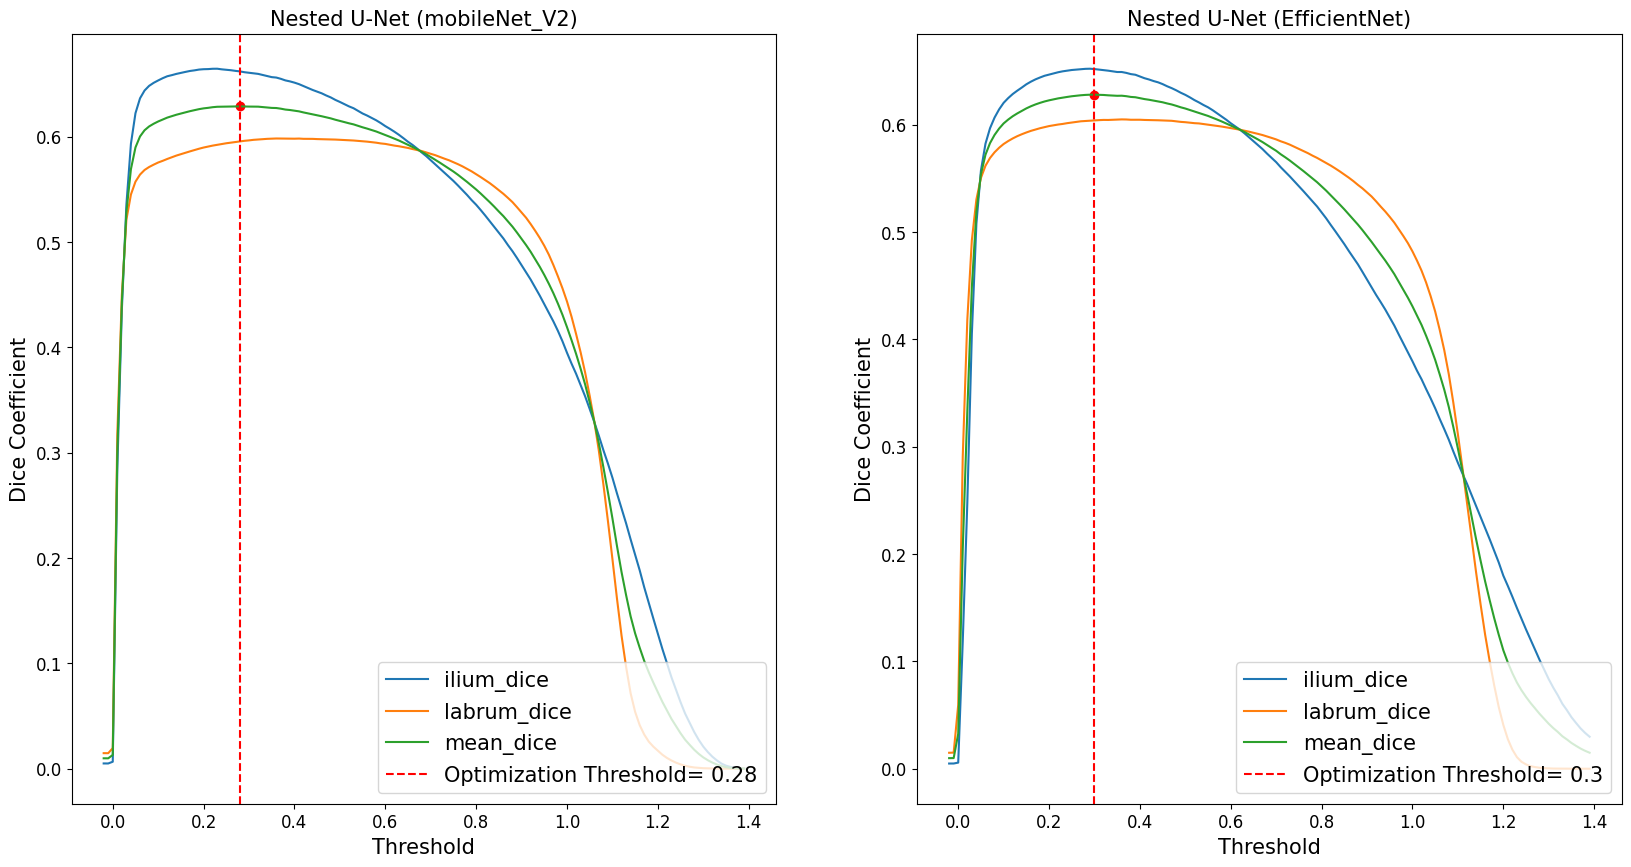

In [8]:

# Assuming you have already defined threshold_list, dsc1_1, dsc1_2, dsc2_1, dsc2_2

plt.figure(figsize=(20,10))

# Subplot 1
plt.subplot(1,2,1)
plt.title('Nested U-Net (mobileNet_V2)',fontsize="15")
plt.plot(threshold_list, dsc1_1, label='ilium_dice')
plt.plot(threshold_list, dsc1_2, label='labrum_dice')
plt.plot(threshold_list, (np.array(dsc1_1) + np.array(dsc1_2))/2, label='mean_dice')
plt.scatter(threshold1, dsc_optim1, color='r', marker='o')
plt.axvline(x=threshold1, color='r', linestyle='--', label='Optimization Threshold= '+str(round(threshold1,3)).zfill(3))  # Add this line to draw a vertical line at x=0.5


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Threshold', size=15)
plt.ylabel('Dice Coefficient', size=15)
plt.legend(fontsize="15", loc="lower right")

# Subplot 2
plt.subplot(1,2,2)
plt.title('Nested U-Net (EfficientNet)', fontsize="15")
plt.plot(threshold_list, dsc2_1, label='ilium_dice')
plt.plot(threshold_list, dsc2_2, label='labrum_dice')
plt.plot(threshold_list, (np.array(dsc2_1) + np.array(dsc2_2))/2, label='mean_dice')
plt.scatter(threshold2, dsc_optim2, color='r', marker='o')
plt.axvline(x=threshold2, color='r', linestyle='--', label='Optimization Threshold= '+str(round(threshold2,3)).zfill(3))  # Add this line to draw a vertical line at x=0.5


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Threshold', size=15)
plt.ylabel('Dice Coefficient', size=15)
plt.legend(fontsize="15", loc="lower right")

plt.show()

In [9]:
def createDirectory(directory):
    """_summary_
        create Directory
    Args:
        directory (string): file_path
    """    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")
for i in tqdm(range(len(NestedUNet_prob))):    
    pred_int_class = torch.where(NestedUNet_prob[i].cpu() >= threshold1, 1, 0)
    pred_int_class = pred_int_class.type(torch.uint8)*255
    
    createDirectory('../../data/segmentationDDH/predict/NestedUNet/pred/'+str(i).zfill(5)+'/')
    createDirectory('../../data/segmentationDDH/predict/NestedUNet/image/')
    createDirectory('../../data/segmentationDDH/predict/NestedUNet/GT/'+str(i).zfill(5)+'/')
    createDirectory('../../data/segmentationDDH/predict/NestedUNet/overlab/')
    ToPILImage()(pred_int_class[0]).save('../../data/segmentationDDH/predict/NestedUNet/pred/'+str(i).zfill(5)+'/1.png')
    ToPILImage()(pred_int_class[1]).save('../../data/segmentationDDH/predict/NestedUNet/pred/'+str(i).zfill(5)+'/2.png')
    ToPILImage()(pred_int_class[2]).save('../../data/segmentationDDH/predict/NestedUNet/pred/'+str(i).zfill(5)+'/3.png')
    ToPILImage()(pred_int_class[3]).save('../../data/segmentationDDH/predict/NestedUNet/pred/'+str(i).zfill(5)+'/4.png')
    x_int_class =NestedUNet_x[i]
    x_int_class = (x_int_class*255).type(torch.uint8)
    ToPILImage()(x_int_class).save('../../data/segmentationDDH/predict/NestedUNet/image/'+str(i).zfill(5)+'.png')
    y_int_class = torch.where(NestedUNet_y[i].cpu() >= threshold1, 1, 0)
    y_int_class = y_int_class.type(torch.uint8)*255
    y_int_class1=y_int_class[0]+y_int_class[1]+y_int_class[2]+y_int_class[3]
    ToPILImage()(y_int_class[0]).save('../../data/segmentationDDH/predict/NestedUNet/GT/'+str(i).zfill(5)+'/1.png')
    ToPILImage()(y_int_class[1]).save('../../data/segmentationDDH/predict/NestedUNet/GT/'+str(i).zfill(5)+'/2.png')
    ToPILImage()(y_int_class[2]).save('../../data/segmentationDDH/predict/NestedUNet/GT/'+str(i).zfill(5)+'/3.png')
    ToPILImage()(y_int_class[3]).save('../../data/segmentationDDH/predict/NestedUNet/GT/'+str(i).zfill(5)+'/4.png')

    x_int_class =NestedUNet_x[i].cpu()
    over_int_class = (x_int_class*128).type(torch.uint8)
    over_int_class[0]=over_int_class[0]+pred_int_class[0]*0.5
    over_int_class[1]=over_int_class[1]+pred_int_class[1]*0.5
    over_int_class[2]=over_int_class[2]+pred_int_class[2]*0.5
    over_int_class[0]=over_int_class[0]+pred_int_class[3]*0.5
    ToPILImage()(over_int_class).save('../../data/segmentationDDH/predict/NestedUNet/overlab/'+str(i).zfill(5)+'.png')

for i in tqdm(range(len(UNet_prob))):    
    pred_int_class = torch.where(UNet_prob[i].cpu() >= threshold2, 1, 0)
    pred_int_class = pred_int_class.type(torch.uint8)*255
    pred_int_class1=pred_int_class[0]+pred_int_class[1]+pred_int_class[2]+pred_int_class[3]
    createDirectory('../../data/segmentationDDH/predict/UNet/pred/'+str(i).zfill(5)+'/')
    createDirectory('../../data/segmentationDDH/predict/UNet/image/')
    createDirectory('../../data/segmentationDDH/predict/UNet/GT/'+str(i).zfill(5)+'/')
    createDirectory('../../data/segmentationDDH/predict/UNet/overlab/')
    ToPILImage()(pred_int_class[0]).save('../../data/segmentationDDH/predict/UNet/pred/'+str(i).zfill(5)+'/1.png')
    ToPILImage()(pred_int_class[1]).save('../../data/segmentationDDH/predict/UNet/pred/'+str(i).zfill(5)+'/2.png')
    ToPILImage()(pred_int_class[2]).save('../../data/segmentationDDH/predict/UNet/pred/'+str(i).zfill(5)+'/3.png')
    ToPILImage()(pred_int_class[3]).save('../../data/segmentationDDH/predict/UNet/pred/'+str(i).zfill(5)+'/4.png')
    x_int_class =UNet_x[i]
    x_int_class = (x_int_class*255).type(torch.uint8)
    ToPILImage()(x_int_class).save('../../data/segmentationDDH/predict/UNet/image/'+str(i).zfill(5)+'.png')
    y_int_class = torch.where(UNet_y[i].cpu() >= threshold2, 1, 0)
    y_int_class = y_int_class.type(torch.uint8)*255
    y_int_class1=y_int_class[0]+y_int_class[1]+y_int_class[2]+y_int_class[3]
    ToPILImage()(y_int_class[0]).save('../../data/segmentationDDH/predict/UNet/GT/'+str(i).zfill(5)+'/1.png')
    ToPILImage()(y_int_class[1]).save('../../data/segmentationDDH/predict/UNet/GT/'+str(i).zfill(5)+'/2.png')
    ToPILImage()(y_int_class[2]).save('../../data/segmentationDDH/predict/UNet/GT/'+str(i).zfill(5)+'/3.png')
    ToPILImage()(y_int_class[3]).save('../../data/segmentationDDH/predict/UNet/GT/'+str(i).zfill(5)+'/4.png')
    x_int_class =UNet_x[i].cpu()
    over_int_class = (x_int_class*128).type(torch.uint8)
    over_int_class[0]=over_int_class[0]+pred_int_class[0]*0.5
    over_int_class[1]=over_int_class[1]+pred_int_class[1]*0.5
    over_int_class[2]=over_int_class[2]+pred_int_class[2]*0.5
    over_int_class[0]=over_int_class[0]+pred_int_class[3]*0.5
    ToPILImage()(over_int_class).save('../../data/segmentationDDH/predict/UNet/overlab/'+str(i).zfill(5)+'.png')
    
for i in tqdm(range(len(DeepLabV3Plus_prob))):    
    pred_int_class = torch.where(DeepLabV3Plus_prob[i].cpu() >= threshold3, 1, 0)
    pred_int_class = pred_int_class.type(torch.uint8)*255
    pred_int_class1=pred_int_class[0]+pred_int_class[1]+pred_int_class[2]+pred_int_class[3]
    createDirectory('../../data/segmentationDDH/predict/DeepLabV3Plus/pred/'+str(i).zfill(5)+'/')
    createDirectory('../../data/segmentationDDH/predict/DeepLabV3Plus/image/')
    createDirectory('../../data/segmentationDDH/predict/DeepLabV3Plus/GT/'+str(i).zfill(5)+'/')
    createDirectory('../../data/segmentationDDH/predict/DeepLabV3Plus/overlab/')
    ToPILImage()(pred_int_class[0]).save('../../data/segmentationDDH/predict/DeepLabV3Plus/pred/'+str(i).zfill(5)+'/1.png')
    ToPILImage()(pred_int_class[1]).save('../../data/segmentationDDH/predict/DeepLabV3Plus/pred/'+str(i).zfill(5)+'/2.png')
    ToPILImage()(pred_int_class[2]).save('../../data/segmentationDDH/predict/DeepLabV3Plus/pred/'+str(i).zfill(5)+'/3.png')
    ToPILImage()(pred_int_class[3]).save('../../data/segmentationDDH/predict/DeepLabV3Plus/pred/'+str(i).zfill(5)+'/4.png')
    x_int_class =DeepLabV3Plus_x[i]
    x_int_class = (x_int_class*255).type(torch.uint8)
    ToPILImage()(x_int_class).save('../../data/segmentationDDH/predict/DeepLabV3Plus/image/'+str(i).zfill(5)+'.png')
    y_int_class = torch.where(DeepLabV3Plus_y[i].cpu() >= threshold3, 1, 0)
    y_int_class = y_int_class.type(torch.uint8)*255
    y_int_class1=y_int_class[0]+y_int_class[1]+y_int_class[2]+y_int_class[3]
    ToPILImage()(y_int_class[0]).save('../../data/segmentationDDH/predict/DeepLabV3Plus/GT/'+str(i).zfill(5)+'/1.png')
    ToPILImage()(y_int_class[1]).save('../../data/segmentationDDH/predict/DeepLabV3Plus/GT/'+str(i).zfill(5)+'/2.png')
    ToPILImage()(y_int_class[2]).save('../../data/segmentationDDH/predict/DeepLabV3Plus/GT/'+str(i).zfill(5)+'/3.png')
    ToPILImage()(y_int_class[3]).save('../../data/segmentationDDH/predict/DeepLabV3Plus/GT/'+str(i).zfill(5)+'/4.png')
    x_int_class =DeepLabV3Plus_x[i].cpu()
    over_int_class = (x_int_class*128).type(torch.uint8)
    over_int_class[0]=over_int_class[0]+pred_int_class[0]*0.5
    over_int_class[1]=over_int_class[1]+pred_int_class[1]*0.5
    over_int_class[2]=over_int_class[2]+pred_int_class[2]*0.5
    over_int_class[0]=over_int_class[0]+pred_int_class[3]*0.5
    ToPILImage()(over_int_class).save('../../data/segmentationDDH/predict/DeepLabV3Plus/overlab/'+str(i).zfill(5)+'.png')
    
for i in tqdm(range(len(PAN_prob))):    
    pred_int_class = torch.where(PAN_prob[i].cpu() >= threshold4, 1, 0)
    pred_int_class = pred_int_class.type(torch.uint8)*255
    pred_int_class1=pred_int_class[0]+pred_int_class[1]
    createDirectory('../../data/segmentationDDH/predict/PAN/pred/'+str(i).zfill(5))
    createDirectory('../../data/segmentationDDH/predict/PAN/image/')
    createDirectory('../../data/segmentationDDH/predict/PAN/GT/'+str(i).zfill(5)+'/')
    createDirectory('../../data/segmentationDDH/predict/PAN/overlab/')
    ToPILImage()(pred_int_class[0]).save('../../data/segmentationDDH/predict/PAN/pred/'+str(i).zfill(5)+'/1.png')
    ToPILImage()(pred_int_class[1]).save('../../data/segmentationDDH/predict/PAN/pred/'+str(i).zfill(5)+'/2.png')
    ToPILImage()(pred_int_class[2]).save('../../data/segmentationDDH/predict/PAN/pred/'+str(i).zfill(5)+'/3.png')
    ToPILImage()(pred_int_class[3]).save('../../data/segmentationDDH/predict/PAN/pred/'+str(i).zfill(5)+'/4.png')
    x_int_class =PAN_x[i]
    x_int_class = (x_int_class*255).type(torch.uint8)
    ToPILImage()(x_int_class).save('../../data/segmentationDDH/predict/PAN/image/'+str(i).zfill(5)+'.png')
    y_int_class = torch.where(PAN_y[i].cpu() >= threshold4, 1, 0)
    y_int_class = y_int_class.type(torch.uint8)*255
    y_int_class1=y_int_class[0]+y_int_class[1]+y_int_class[2]+y_int_class[3]
    ToPILImage()(y_int_class[0]).save('../../data/segmentationDDH/predict/PAN/GT/'+str(i).zfill(5)+'/1.png')
    ToPILImage()(y_int_class[1]).save('../../data/segmentationDDH/predict/PAN/GT/'+str(i).zfill(5)+'/2.png')
    ToPILImage()(y_int_class[2]).save('../../data/segmentationDDH/predict/PAN/GT/'+str(i).zfill(5)+'/3.png')
    ToPILImage()(y_int_class[3]).save('../../data/segmentationDDH/predict/PAN/GT/'+str(i).zfill(5)+'/4.png')
    x_int_class =PAN_x[i].cpu()
    over_int_class = (x_int_class*128).type(torch.uint8)
    over_int_class[0]=over_int_class[0]+pred_int_class[0]*0.5
    over_int_class[1]=over_int_class[1]+pred_int_class[1]*0.5
    over_int_class[2]=over_int_class[2]+pred_int_class[2]*0.5
    over_int_class[0]=over_int_class[0]+pred_int_class[3]*0.5
    ToPILImage()(over_int_class).save('../../data/segmentationDDH/predict/PAN/overlab/'+str(i).zfill(5)+'.png')

  0%|          | 0/584 [00:00<?, ?it/s]

 18%|█▊        | 103/584 [00:22<01:44,  4.62it/s]


KeyboardInterrupt: 